# SECOND PART OF THE PROJECT
Classification Problem

In [25]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn import svm

from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [26]:
# load data
data = pd.read_csv("../DATASET/shot_logs_cleaned.csv",index_col = 0)

# droping useless columns
# FGM and PTS are perfectly correlated with SHOT_RESULT
data = data.drop(['MATCHUP', 'CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID', 'player_name', 'player_id','FGM','PTS','LOCATION_A','W_L','SHOT_RESULT_missed'], axis=1)

# droping rows with negative in any column
data = data[(data[['FINAL_MARGIN','SHOT_NUMBER','PERIOD','GAME_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST']] >= 0).all(axis=1)]

data.head()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,LOCATION_H,W_W,SHOT_RESULT_made
GAME_ID,,,,,,,,,,,,
21400899,24,1,1,1.150000,2,1.9,7.7,2,1.3,0.0,1.0,1.0
21400899,24,2,1,0.233333,0,0.8,28.2,3,6.1,0.0,1.0,0.0
21400899,24,3,1,0.000000,3,2.7,10.1,2,0.9,0.0,1.0,0.0
21400899,24,4,2,11.783333,2,1.9,17.2,2,3.4,0.0,1.0,0.0
21400899,24,5,2,10.566667,2,2.7,3.7,2,1.1,0.0,1.0,0.0


- Feature transformation

The shot_dist feature is going to be transformed into grades.

In [27]:
# information about the features
data['SHOT_DIST'].describe()

count    64443.000000
mean        13.619890
std          8.906727
min          0.100000
25%          4.700000
50%         13.900000
75%         22.600000
max         45.300000
Name: SHOT_DIST, dtype: float64

In [28]:
# transforming the feature
#data['SHOT_DIST'] = pd.cut(data['SHOT_DIST'], bins=[-0.1, 4, 10, 15, 23, 27, 50], labels=[1, 2, 3, 4, 5, 6])

# adding total game time with game clock and period
data['TOTAL_GAME_TIME'] = data['GAME_CLOCK'] + (data['PERIOD']-1)*12

# removing game clock and period
data = data.drop(['GAME_CLOCK','PERIOD'], axis=1)

# droping rows with negative in any column
data = data[(data[['FINAL_MARGIN','SHOT_NUMBER','DRIBBLES','TOUCH_TIME','PTS_TYPE','CLOSE_DEF_DIST']] >= 0).all(axis=1)]

data.head()

,FINAL_MARGIN,SHOT_NUMBER,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,LOCATION_H,W_W,SHOT_RESULT_made,TOTAL_GAME_TIME
GAME_ID,,,,,,,,,,,
21400899,24,1,2,1.9,7.7,2,1.3,0.0,1.0,1.0,1.150000
21400899,24,2,0,0.8,28.2,3,6.1,0.0,1.0,0.0,0.233333
21400899,24,3,3,2.7,10.1,2,0.9,0.0,1.0,0.0,0.000000
21400899,24,4,2,1.9,17.2,2,3.4,0.0,1.0,0.0,23.783333
21400899,24,5,2,2.7,3.7,2,1.1,0.0,1.0,0.0,22.566667


+ Data split

Selecting the features and the target.

In [29]:
X = data.drop('SHOT_RESULT_made', axis=1)
y = data['SHOT_RESULT_made']

Splitting the dataset into train and test.

In [30]:
# ratio 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

LOGISTIC REGRESSION

Accuracy: 0.59
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62      3369
         1.0       0.57      0.52      0.55      3076

    accuracy                           0.59      6445
   macro avg       0.58      0.58      0.58      6445
weighted avg       0.59      0.59      0.58      6445



c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


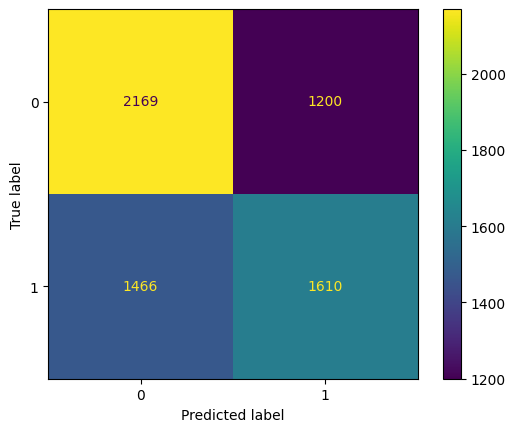

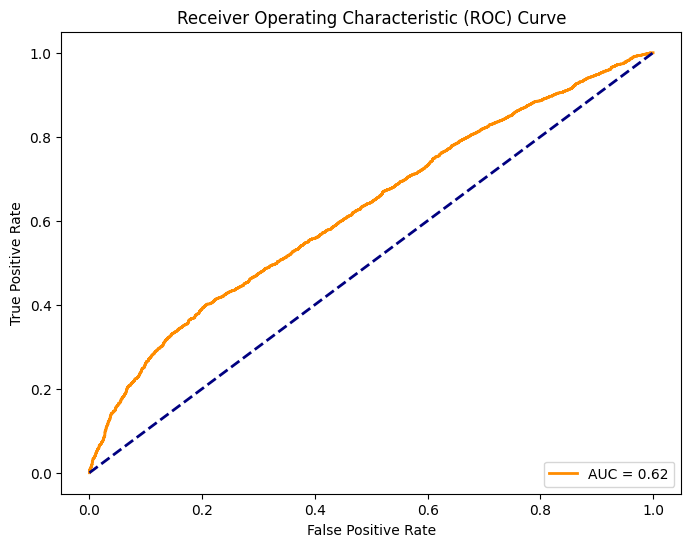

Paper's results for Logistic Regression is 0.59 that is pretty similar to our result
Confusion matrix is different, maybe because of the number of data, in the article, the total sum of the matrix is 5000, in our case is 6445


In [31]:
# α = 10, λ = 0.0001 and gradient descent
model = LogisticRegression(C=10, penalty='l2', solver='saga', max_iter=10000)
model.fit(X_train_std, y_train)

# prediction
y_pred = model.predict(X_test_std)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# classification report
print(classification_report(y_test, y_pred))

# ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Paper's results for Logistic Regression is 0.59 that is pretty similar to our result")
print("Confusion matrix is different, maybe because of the number of data, in the article, the total sum of the matrix is 5000, in our case is 6445")

SVM

c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.54
              precision    recall  f1-score   support

         0.0       0.56      0.62      0.59      3369
         1.0       0.53      0.46      0.49      3076

    accuracy                           0.54      6445
   macro avg       0.54      0.54      0.54      6445
weighted avg       0.54      0.54      0.54      6445

Paper's results for SVM is 0.53 that is pretty close to our result
Confusion matrix is similar but doesn't have the same size


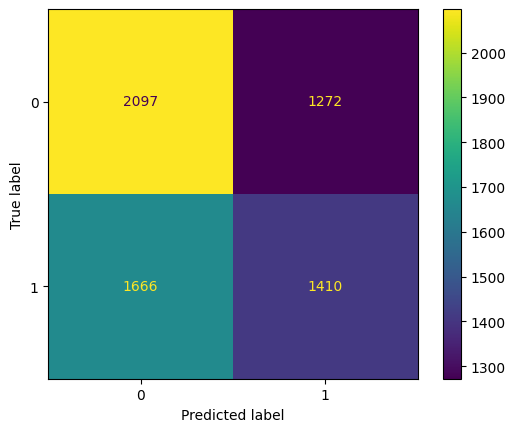

In [32]:
model = svm.SVC(C=10, max_iter=1000)
model.fit(X_train_std, y_train)

# prediction
y_pred = model.predict(X_test_std)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# classification report
print(classification_report(y_test, y_pred))

print("Paper's results for SVM is 0.53 that is pretty close to our result")
print("Confusion matrix is similar but doesn't have the same size")

NAIVE BAYES

Accuracy: 0.58
              precision    recall  f1-score   support

         0.0       0.60      0.61      0.60      3369
         1.0       0.57      0.56      0.56      3076

    accuracy                           0.58      6445
   macro avg       0.58      0.58      0.58      6445
weighted avg       0.58      0.58      0.58      6445



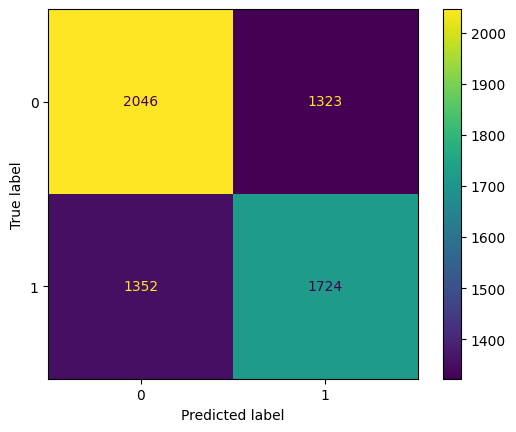

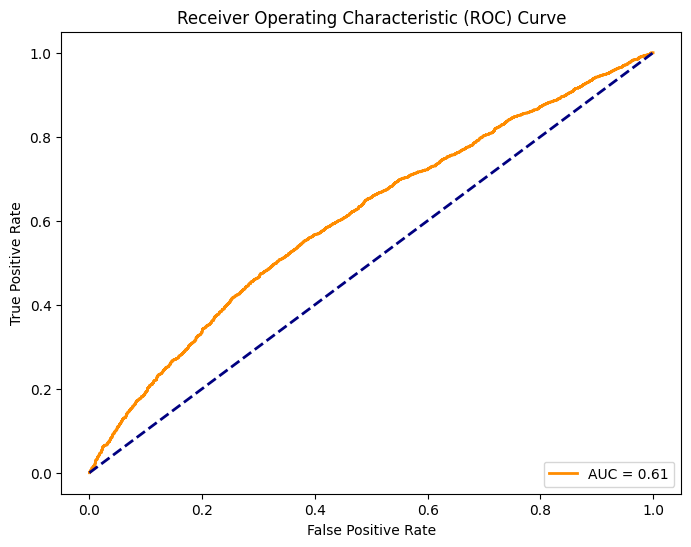

Paper's results for Naive Bayes is 0.54 that is similar to our result
Confusion matrix is so different, our matrix has more true positive and true negative than false positive and false negative


In [33]:
model = MultinomialNB()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# classification report
print(classification_report(y_test, y_pred))

# ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Paper's results for Naive Bayes is 0.54 that is similar to our result")
print("Confusion matrix is so different, our matrix has more true positive and true negative than false positive and false negative")

BOOSTING

Accuracy: 0.52


              precision    recall  f1-score   support

         0.0       0.52      1.00      0.69      3369
         1.0       0.00      0.00      0.00      3076

    accuracy                           0.52      6445
   macro avg       0.26      0.50      0.34      6445
weighted avg       0.27      0.52      0.36      6445



c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

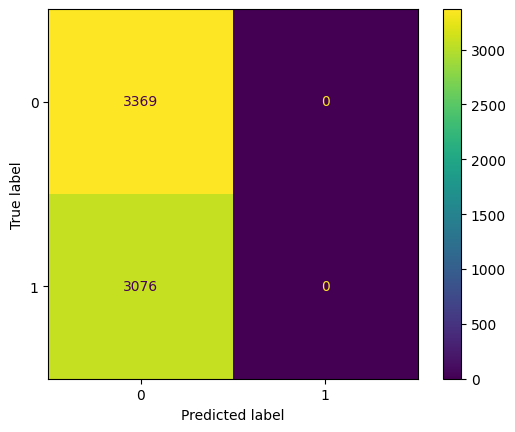

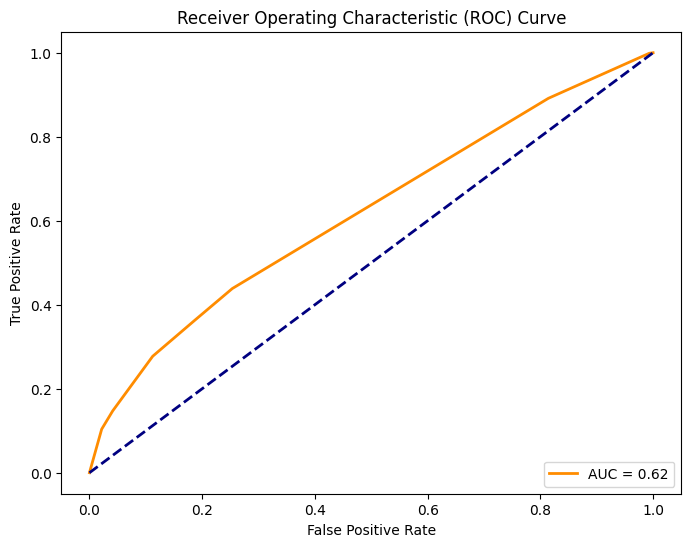

Paper's results for XGBoost is 0.50-0.60 that is similar to our result
Confusion matrix is really different, I set the same parameters to the model but the result is different.


In [34]:
# 1 estimator, learning rate α = 0.0001, max depth 3, and a minimum child node weight of 0.0001.
model = xgb.XGBClassifier(n_estimators=1, learning_rate=0.0001, max_depth=3, min_child_weight=0.0001)
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# classification report
print(classification_report(y_test, y_pred))

# ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Paper's results for XGBoost is 0.50-0.60 that is similar to our result")
print("Confusion matrix is really different, I set the same parameters to the model but the result is different.")

RANDOM FOREST CLASSIFIER

Accuracy: 0.61
              precision    recall  f1-score   support

         0.0       0.59      0.79      0.68      3369
         1.0       0.64      0.40      0.49      3076

    accuracy                           0.61      6445
   macro avg       0.62      0.60      0.58      6445
weighted avg       0.61      0.61      0.59      6445



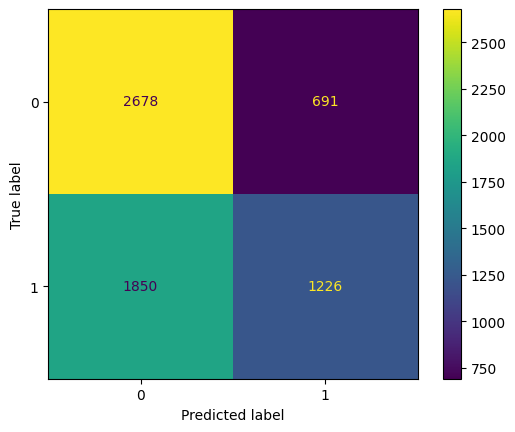

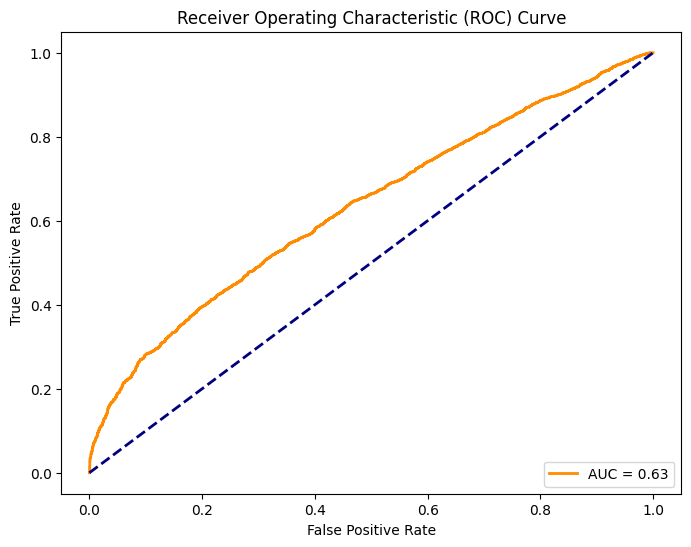

Paper's results for Random Forest is 0.61 that is similar to our result
Confusion matrix is different


In [35]:
# 80 trees, 50 minimum leaves, and sampling without replacement
model = RandomForestClassifier(n_estimators=80, min_samples_leaf=50, bootstrap=True)
model.fit(X_train,y_train)

# prediction
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# classification report
print(classification_report(y_test, y_pred))

# ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Paper's results for Random Forest is 0.61 that is similar to our result")
print("Confusion matrix is different")

- Conclusion

The best model for the paper is the Random Forest Classifier and boosting but for me the best model is the Logistic Regression and Random Forest Classifier talking about the accuracy of each model.
The confusion matrix of the models are very different. I think that it is because of the different size of the dataset.
I tried to do the Neural Network but I had some problems with the installation of the packages so I couldn't do it. I have tried to do it with tensorflow and pytorch.
I categorized the shot_dist feature because I thought that it was going to be better for the models but finally it was not and I commented the that part of the code.

Concluding, I have learned a lot about machine learning algorithms and how to use them and their potential in binary classification problems.